<a href="https://colab.research.google.com/github/nicologhielmetti/AN2DL-challenges/blob/master/challenge2/Multiclass_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1iJ3O6mZduuaf_97eszLzVLyU5SaLvBE1
!unzip /content/Development_Dataset.zip


In [ ]:
import os
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input 
import time
from matplotlib import cm
import matplotlib.pyplot as plt


SEED = 1234
tf.random.set_seed(SEED)  

In [ ]:
cwd = os.getcwd()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_img = mask_img.resize([256,256],resample=Image.NEAREST)
    mask_arr = np.array(mask_img)
  
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    return new_mask_arr

In [ ]:
# ImageDataGenerator, check if it works properly

apply_data_augmentation = True

# Create training ImageDataGenerator object, we need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:


class CustomDataset(tf.keras.utils.Sequence):


  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[ 256,256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask = read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
  

    # Resize image and mask

    img = img.resize(self.out_shape)
    
    img_arr = np.array(img)

    mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds to the contours of the objects. We remove it for simplicity.
    
    mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            curr_class_arr = np.uint8(curr_class_arr)
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
img_h = 256
img_w = 256

dataset = CustomDataset('/content/Development_Dataset', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen)
dataset_valid = CustomDataset('/content/Development_Dataset', 'validation')

In [ ]:

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w,3], [img_h, img_w,1]))

train_dataset = train_dataset.batch(8)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(8)

valid_dataset = valid_dataset.repeat()

In [ ]:
#Test data generator

%matplotlib inline

# Assign a color to each class

evenly_spaced_interval = np.linspace(0, 1, 20)

colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

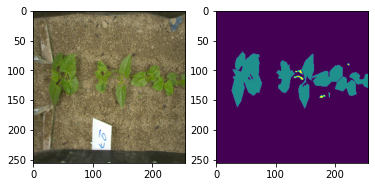

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   
augmented_img = augmented_img      

target = np.array(target[0, ..., 0])  

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(0,3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target))

plt.show()

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()

finetuning = True

if finetuning:
    freeze_until = 5 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False

In [ ]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
   
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=3)

# Visualize created model as a table
model.summary()

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(0,3): 
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics

metrics = ['accuracy', meanIoU]


# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
train = False
if (train):
  

  cwd = os.getcwd()

  exps_dir = os.path.join(cwd, 'drive/MyDrive/Keras4/', 'multiclass_segmentation_experiments')
  if not os.path.exists(exps_dir):
     os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  model_name = 'CNN'

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

# Model checkpoint

  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                  save_best_only=True, save_weights_only=True)  # False to save the model directly
  callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard

  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
  callbacks.append(tb_callback)

# Early Stopping

  early_stop = True
  if early_stop:
      es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights= True)
      callbacks.append(es_callback)


  model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [ ]:
model.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec08_10-10-30/ckpts/cp_02.ckpt')

In [ ]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [ ]:
#Prepare Submission
def rle_encode(img):
    ''' img: numpy array, 1 - foreground, 0 - background.Returns run length as string formatted'''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
test_path = '/content/Development_Dataset/Test_Dev/Bipbip/Haricot/Images'
test_elements = getListOfFiles(test_path)

In [ ]:
test_dataset = list()
for elem in test_elements:
  img = Image.open(elem)
  img = img.resize([256,256],resample=Image.NEAREST)
  img = np.array(img)
  test_dataset.append(img)
iterator = iter(test_dataset)

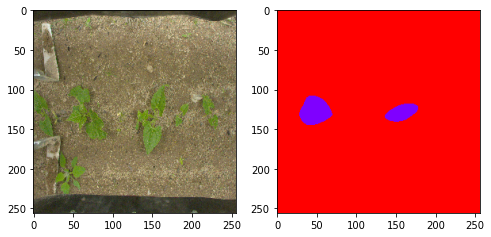

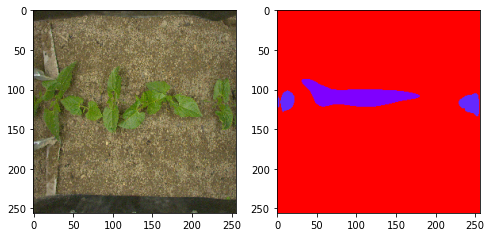

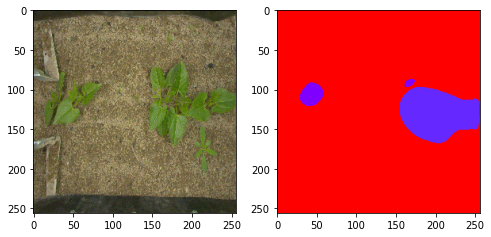

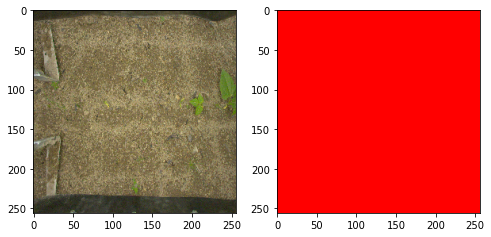

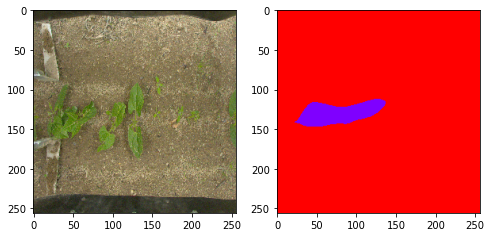

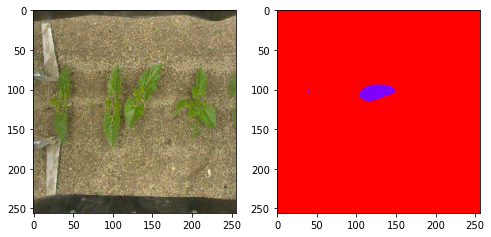

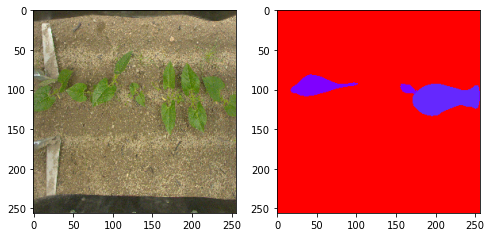

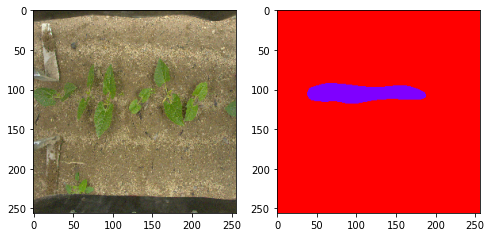

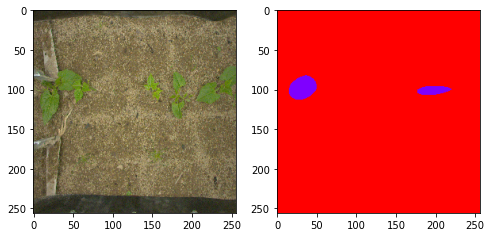

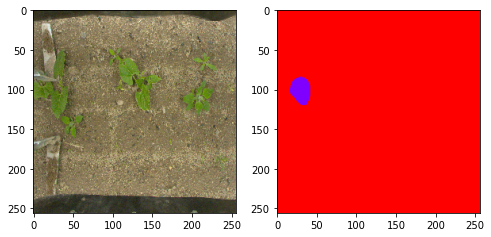

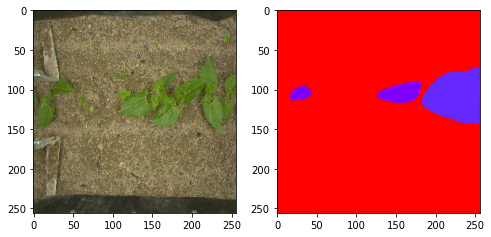

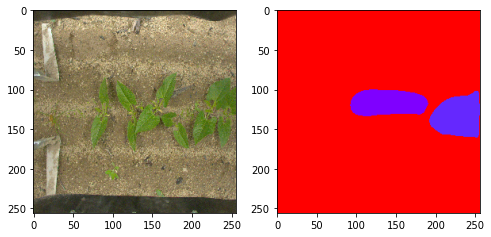

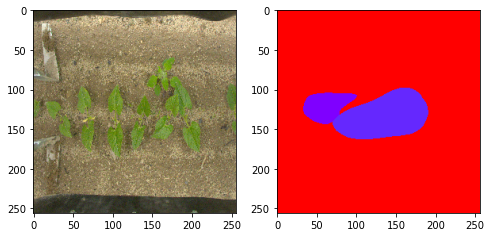

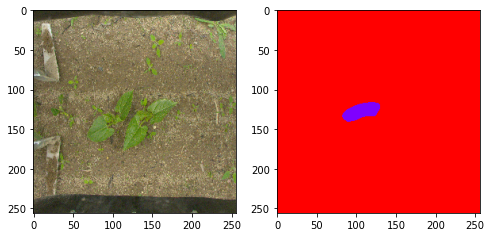

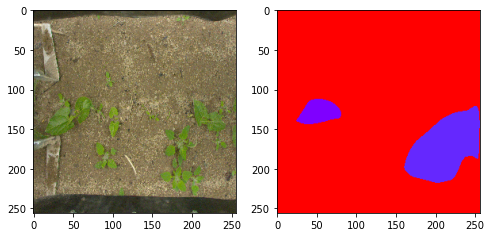

In [ ]:
import json
predictions = []

for i in range(0,15):

  image = next(iterator)

  out_sigmoid = model.predict(x=tf.expand_dims(image, 0)) 

  predicted_mask = tf.argmax(out_sigmoid, -1)               #masks

  mask_arr = np.array(predicted_mask)                     #converted
 
  predictions.append(mask_arr)  #TODO: try to append the images after the visualization, maybe it solves the problem of multicolor

#Visualization

  fig, ax = plt.subplots(1, 2, figsize=(8, 8))

  fig.show()

  predicted_mask = predicted_mask[0, ...]

  prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

  prediction_img[np.where(predicted_mask == 0)] = [0, 0, 0]

  for i in range(0,3):

    prediction_img[np.where(predicted_mask == i)] = np.array(colors[i-1])[:3] * 255

  
  ax[0].imshow(np.uint8(image))

  ax[1].imshow(np.uint8(prediction_img))

  fig.canvas.draw()

  time.sleep(1)
#End of visualization 


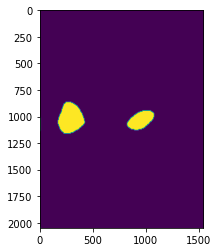

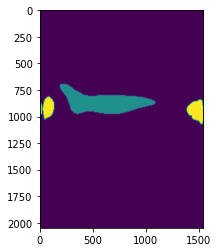

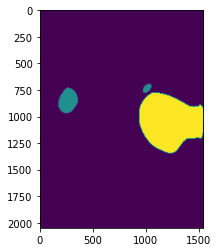

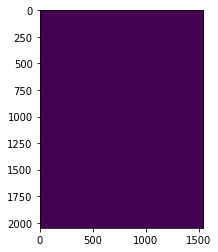

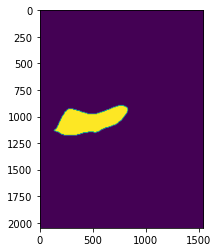

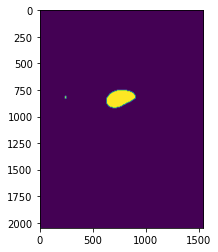

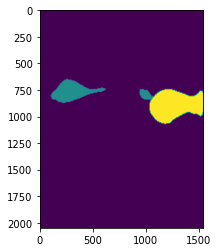

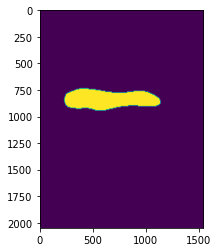

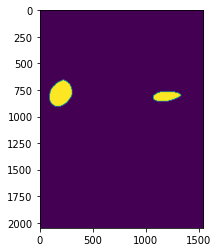

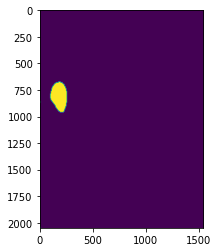

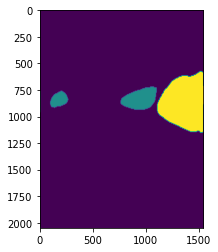

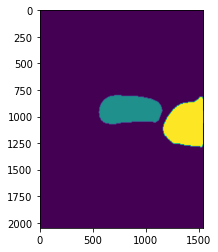

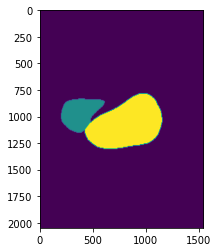

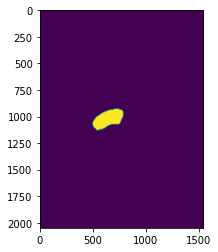

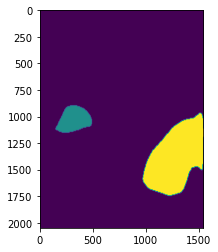

In [ ]:
resize_shape = (2048,1536)
for i in range(len(predictions)):    #not sure it is working properly
  pred = predictions[i]
  squeezed = tf.squeeze(pred)         #From 1x256x256 to 256x256
  squeezed = tf.expand_dims(squeezed,2)   #From 256x256 to 256x256x1
  squeezed = np.array(squeezed)
  squeezed = tf.image.resize(squeezed, resize_shape)      #From 256x256x1 to 1536x2048x1
  predictions[i] = np.array(tf.squeeze(squeezed))         
  #visualization
  squeezed = tf.squeeze(squeezed)    #must be D1XD2 to be shown
  plt.imshow(squeezed)
  plt.show()
    
     
   

In [ ]:
#TODO: FILL THE DICTIONARY WITH THE STRINGS RELATIVE TO THE OTHER PROJECTS
!gdown https://drive.google.com/uc?id=17GZHCD4QDvRItngD-MRmNXOwgI5rU_9A
!unzip /content/Test_Dev.zip

In [ ]:
teams = ["Bipbip","Pead","Roseau","Weedelec"]
crops = ["Haricot","Mais"]

In [ ]:
submission_dict = {}
i = 0
  #we perform the predictions only with a dataset, for the others it is required to put empty string for the submission
                          # Prediction dataset --> Haricot, Bipbip
for team in teams:
  for crop in crops:
    if ((team == "Bipbip") and (crop == "Haricot") ):
      for el in test_elements:      #create all the keys, this might be redoundant code
        img_path = el
        img_name = os.path.basename(img_path)
        img_name = img_name[:len(img_name)-4]
        submission_dict[img_name] = {}
      for _id in predictions:        #Adding information for keys that matches the value
          img_path = test_elements[i]
          i = i+1
          img_name = os.path.basename(img_path)
          img_name = img_name[:len(img_name)-4]
          submission_dict[img_name]['shape'] = _id.shape
          submission_dict[img_name]['team'] = team
          submission_dict[img_name]['crop'] = crop
          submission_dict[img_name]['segmentation'] = {}
          rle_encoded_crop = rle_encode(_id == 1)
          rle_encoded_weed = rle_encode(_id == 2)
          submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
          submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
    
    else:
      img_path = '/content/Test_Dev/'
      img_list = getListOfFiles(img_path + str(team) +'/' + str(crop) + '/Images')
      for img in img_list:     
        img_name = os.path.basename(img)
        img_name = img_name[:len(img_name)-4]
        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = (2048,1536)
        submission_dict[img_name]['team'] = team
        submission_dict[img_name]['crop'] = crop
        submission_dict[img_name]['segmentation'] = {}
        submission_dict[img_name]['segmentation']['crop'] = ""
        submission_dict[img_name]['segmentation']['weed'] = ""

In [ ]:
submission_dict

In [ ]:
with open('submission.json', 'w') as f:   #dumps the dictionary into the json
  json.dump(submission_dict, f)

In [ ]:
from google.colab import files
files.download('submission.json') 

In [ ]:
def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

decode = True
if decode:

    with open('submission.json', 'r') as f:
        submission_dict = json.load(f)

    img_name = 'Bipbip_haricot_im_03691'
    img_shape = submission_dict[img_name]['shape']

    rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
    rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

    
    crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
    weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

    reconstructed_mask = crop_mask + (weed_mask * 2)
    reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
    reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
    reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

    reconstructed_rgb_img = Image.fromarray(
        np.uint8(reconstructed_rgb_arr))
    
    reconstructed_rgb_img